# アンサンブル学習

さまざまな分類器を組み合わせることで個別に使用するより高い汎化性能を得る手法<br>
もっともよく知られるアンサンブル法は多数決の原理を利用するもの。式で表すと以下<br>

$$
\hat{y} = mode \left\{ C_{1}(x), C_{2}(x), \cdots , C_{m}(x) \right\}
$$

$C_j$は個々の分類器での予測、modeは最頻値を表す<br>

例えばクラス1=-1、クラス2=+1の2値分類タスクでは、多数決予測を以下のように記述できる

$$
C(X) = sign \left[ \sum_j^mC_j(x)\right] = 
  \begin{cases}
    1 & (\sum_jC_j(x) \ge 0) \\
    -1 & (\sum_jC_j(x) \lt 0) \\
  \end{cases}
$$
mは分類器の数、signは三角関数ではなく、xが0以上の時、1を、0未満の時、-1を返す関数<br>
2値分類を行う際のn個の分類器の誤分類確率がすべて$\epsilon$で、かつそれぞれの分類器が独立し、誤分類率に相関がない場合、<br>
アンサンブル分類器が誤分類する確率$\epsilon_{ensemble}$は個別の分類器が過半数誤分類する確率として以下のように表せる
$$
P(y \ge k) = \sum_k^n \left< \begin{array}{cc} n \\ k \\ \end{array} \right> \epsilon^k(1 - \epsilon)^{n - k} = \epsilon_{ensemble}
$$
ここで$\left< \begin{array}{cc} n \\ k \\ \end{array} \right> $はn個の内、k個を抽出する組み合わせの個数を表す2項係数<br>
アンサンブルの誤分類率は、個々の分類器の誤分類率が50%未満の場合は、分類器を単体で使用するより低くなることを以下で示す

In [1]:
# 上記の関数を実装
from scipy.misc import comb
import math
def ensemble_error(n_classifier, error):
    # 開始位置はnの半数+1 ceilは切り上げ
    k_start = int(math.ceil(n_classifier / 2.0))
    # <n,k>の部分はcomb(ination)で計算 
    probs = [comb(n_classifier, k) * error ** k * (1 - error) ** (n_classifier - k) for k in range(k_start, n_classifier + 1)]
    # すべての値を合計して返す
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

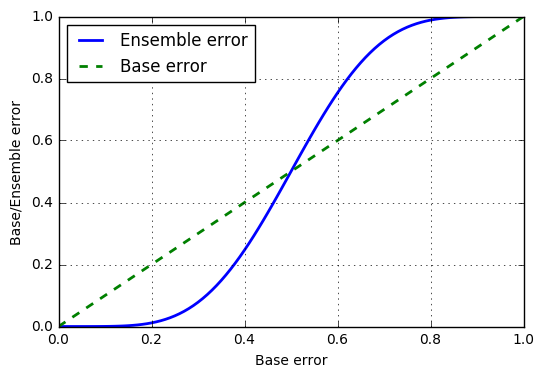

In [2]:
# 個々の分類器とアンサンブル分類器の誤分類率の関係をグラフ化
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

上記のグラフから$\epsilon \lt 0.5$のときアンサンブル学習はもともとの分類器単体よりも性能が出ることが分かる

#### 単純な多数決分類器の実装

多数決を数学的に正確に表すと以下のようになる
$$
\hat{y} = \underset{i}{argmax} \sum_{j=1}^m w_j \chi_A (C_j(x) = i)
$$

$\hat{y}$はアンサンブルで予測されたクラスラベル、$w_j$は各分類機の重み、$\chi_A$は$[(C_j(x) = i)(\in A)]$の特性関数（確率分布を定義する関数）<br>で、Aはクラスラベルの集合を表す。<br>
特性関数…例えばi=0の時、$i_0=1, i_1=0$を返し、i=1の時$i_0=0, i_1=1$を返す関数($i_0 + i_1 = 1$)<br>
それぞれの分類器の重みを等しくすると、前述の
$$
\hat{y} = mode \left\{ C_{1}(x), C_{2}(x), \cdots , C_{m}(x) \right\}
$$
と同じになる<br>
アンサンブルの分類器がうまく調整されている（確率の合計が1になる）場合は以下のように確率を多数決に利用できる
$$
\hat{y} = \underset{i}{argmax} \sum_{j=1}^m w_j p_{ij}
$$
$p_{ij}$はクラスラベルiに対してj番目の分類器が予測した確率を表す<br>

In [3]:
# 多数決分類器の実装
# estimatorの基底クラス set_paramsやget_paramsメソッドを提供
from sklearn.base import BaseEstimator
# ClassifierMixinはscoreメソッドを提供
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

# クラス（継承したいクラス, …）で継承
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    多数決アンサンブル分類器
    
    パラメータ
    -----------
    classifiers : array-like, shape = [n_classifiers]
      アンサンブルの様々な分類器
      
    vote : str, {'classlabel', 'probability'} (default: 'classlabel')
      'classlabel'のとき、予測はクラスラベルのargmaxに基づく
      'probability'のとき、予測は所属確率のargmaxに基づく
      
    weights : array-like, shape = [n_classifiers] (optional, default=None)
      'int'または'float'型のリストが提供された場合、分類器の重み付けが行われる。Noneの場合は行わない。
    
    """
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """
        分類器を学習させる
        
        パラメータ
        -----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
          トレーニングサンプルからなる行列
        y : array-like, shape = [n_samples]
          クラスラベルのベクトル
          
        戻り値
        -----------
        self : object
        """
        
        # LabelEncoderを使ってクラスラベルが0から始まるようにエンコードする（np.argmaxのため）
        self.lablenc_ = LabelEncoder()
        # エンコード規則の学習
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        # 学習済の分類器を入れる配列
        self.classifiers_ = []
        for clf in self.classifiers:
            # cloneでdeep copy transformでエンコード
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            # 学習したら配列に追加
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """
        Xのクラスラベルを予測する
        
        パラメータ
        ------------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
          トレーニングサンプルからなる行列
          
        戻り値
        ------------
        maj_vote : array-like, shape = [n_samples]
          サンプル毎の予測されたクラスラベル
        """
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel'の場合
            
            # clf.predictで学習済分類器の予測結果を収集 asarray->配列に変換
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            
            # 各サンプルのクラスに対応する確率に重みを掛けて足し合わせた値が最大となる列番号を配列として返す
            maj_vote = np.apply_along_axis( # 第1引数で指定した関数を、第2引数で指定した軸に沿って第3引数で指定した配列に適用する
                lambda x:
                np.argmax(np.bincount(x, weights=self.weights)), # bincountで頻度をカウント weightsで頻度に重みを掛けられる argmaxで頻度が最大のものを返す
                axis=1,
                arr=predictions
            )
            
        # エンコードしたものを元に戻す
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
            
    def predict_proba(self, X):
        """
        Xのクラス確率を予測する
        
        パラメータ
        ------------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
          トレーニングサンプルからなる行列
          
        戻り値
        ------------
        avg_proba : array-like, shape = [n_samples, n_classes]
          各サンプルに対する各クラスで重みづけた平均確率
        """

        # 学習済の分類器で、各クラスの確率を算出 
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        # 指定した軸に対し、重みを掛けて平均を返す
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        
        return avg_proba
    
    def get_params(self, deep=True):
        """
        GridSearchの実行時に分類器のパラメータ名を取得
        """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            # キーを 分類器の名前__パラメータ名、バリューを パラメータの値 とするディクショナリを作成
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [4]:
# 確認用にデータを読み込み
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

# トレーニングデータとテストデータを50%ずつに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [5]:
# 単体の分類器の性能をAUCで確認
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# ロジスティック回帰、k近傍アルゴリズムは特徴量の尺度に影響を受けるため、標準化する
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe2], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [6]:
# 実装したMajorityVoteClassifierを加えて比較
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe2])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe2, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


アンサンブル学習の分類器は他の10分割交差検証の個々の分類器の評価を大幅に上回っている

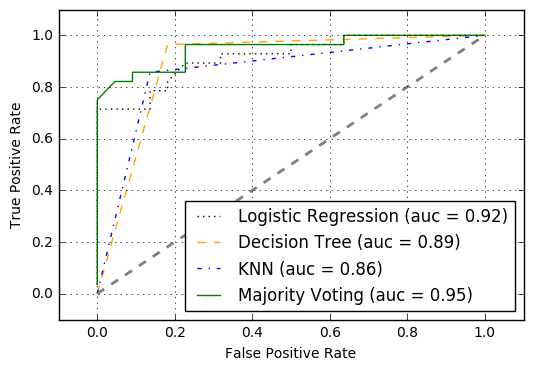

In [7]:
# アンサンブル分類器が未知のデータに汎化しているかROC曲線で確認する
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # テストデータは分類器の汎化性能の偏りがない推定量を算出するためだけに利用する
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')

# ランダムに判定した場合の線をプロット
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

アンサンブル分類器はテストデータセットでも十分な性能を発揮するが、k近傍分類器はトレーニングデータセットのAUCと比較して差があり、<br>
過学習の兆候があることが見られる

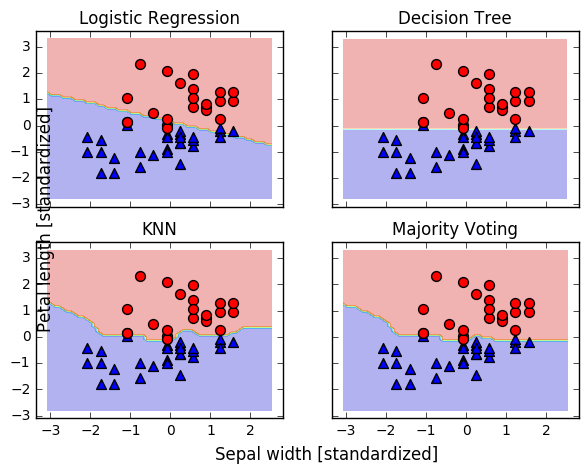

In [8]:
# アンサンブル分類器の決定領域がどのようになるのか確認する
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
# 決定領域を描画する最小値、最大値を生成
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

# グリッドポイントを生成
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# 描画領域を2行2列に分解
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))
# 決定領域のプロット productで01全ての掛け合わせのタプル生成
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # カラーマップを描画
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    # y==0をプロット
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    # y==1をプロット
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='red', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

アンサンブル学習の決定領域はそれぞれの分類器の決定領域を掛けあわせたようにみえる

In [9]:
# get_paramsを呼び出し -> 分類器__パラメータ名 でアクセスできる
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_split': 1e-07,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_

In [10]:
# ロジスティック回帰の正則化パラメータと決定木の深さをチューニング
from sklearn.grid_search import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train_std, y_train)

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r" % (mean_score, scores.std() / 2, params))
    
print('Best paramaters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.967+/-0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1}
0.967+/-0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1}
1.000+/-0.00 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
0.967+/-0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2}
0.967+/-0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2}
1.000+/-0.00 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 2}
Best paramaters: {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
Accuracy: 1.00


上記から正則化の強さを低くした場合が最も交差検証の効果がよく、木の深さは性能に影響を与えていないことが分かる

## バギング

Bootstrap AGGregatINGの略<br>
実装した方法と似ているが、トレーニングデータセットからブートストラップ標本を抽出する（ランダムな復元抽出）<br>
バギングアルゴリズムはバリアンスの抑制に効果的だが、バイアスの抑制には効果がない<br>
このためベースの分類器には剪定されていない決定木などバイアスが低い分類器からなるアンサンブルを選択するとよい<br>

In [11]:
# wineデータの準備
import pandas as pd
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of Ash', 'Magnesium', 'Total phenols', 'Flavonoids',
                  'Nonflavomoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
# クラスラベルが2, 3のもののみ抽出
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine[['Class label']].values
X = df_wine[['Alcohol', 'Hue']].values

# クラスラベルを2値でエンコードし、トレーニングデータとテストデータに分割
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# scikit-learnに実装されているBaggingClassifierを用い、選定されていない決定木をベース分類器として使用する
from sklearn.ensemble import BaggingClassifier
# max_depth=Noneで決定木の深さに最大値を設けない
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

In [13]:
# ベースの分類器単体と、バギング分類器でトレーニングデータ、テストデータでの正解率を計算、比較する
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred  =tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.896


どちらもトレーニングデータの正解率は100%だが決定木はテストデータの正解率が低く、バリアンスが高い/過学習を起こしている<br>
バギングの方は比較的テストデータの正解率が高い

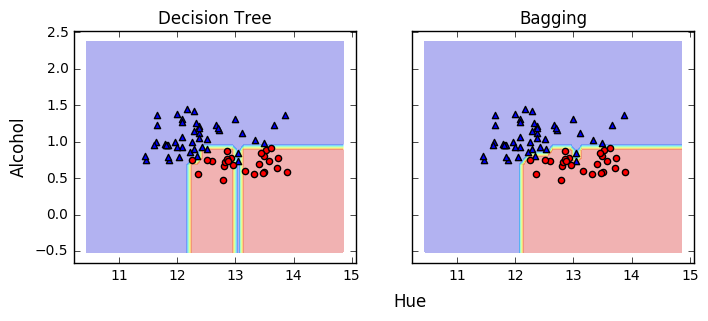

In [14]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))
for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()

### アダブースト

ブースティングは非常に単純なベース分類器で構成されるアンサンブル学習の手法<br>
ベース分類器の性能は当て推量を僅かに上回る程度で、弱学習器と呼ばれる<br>
ブースティングは、誤分類されたサンプルをあとから弱学習器に学習させることで性能を向上させている<br>
ブースティングの手法はトレーニングデータセットからランダムに非復元抽出されたサブセットを学習に用いるが、<br>
アダブーストではトレーニングデータセット全体を用いて弱学習器を学習させる<br>
また、重みのパラメータがあり、誤分類したサンプルの重みを重く、正解のサンプルの重みを軽くして、次の学習器が学習することで、<br>
誤った分類を修正しやすくしている<br>
アダブーストの手順は以下<br>

1. トレーニングサンプルの重みベクトル$\bf w$を設定し$\sum_i w_i = 1$になるように全てのサンプルの重みを等しくする
2. 合計m回のブースティングで以下の3-8を繰り返す
3. 重み付けされたサンプルデータとラベルデータを入力し弱学習器$C_j (1 \le j \le m)$をトレーニングする
4. $C_j$でクラスラベル$\bf \hat{y}$を予測する
5. $C_j$の誤分類率 $\epsilon$を以下のように計算する<br>
$\epsilon = w \cdot (\hat{y} \ne y) $
6. 重みの更新に用いる係数$\alpha_j = 0.5 log \frac{1 - \epsilon}{\epsilon}$を計算する
7. 以下の式で重みを更新する<br>
$\bf w := w \times exp(-\alpha_j \times \hat{y} \times y)$ … 正解（符号があっている）時は右辺は小さくなり、誤り（符号が違う）時は右辺は大きくなる
8. 重みを正規化して合計が1になるようにする<br>
$\sum_i w_i = 1$
9. 特徴量$\bf X$に対する最終予測$\hat{y}$を計算する<br>
$\hat{y} = \left[ \sum_{j=1}^m \left( \alpha_j \times predict(C_j, X) \right) \gt 0 \right]$ ... $\alpha_j$で重み付けした予測結果の平均が0より大きければ$y_i = 1$、小さければ$y_i = -1$とする。

In [15]:
# scikit-learn のアダブーストを実行する
from sklearn.ensemble import AdaBoostClassifier
# 木の深さが1の弱分類器
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=0)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test  accuracies %.3f/%.3f' % (tree_train, tree_test))
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test  accuracies %.3f/%.3f' % (ada_train, ada_test))

Decision tree train/test  accuracies 0.845/0.854
AdaBoost train/test  accuracies 1.000/0.875


Decision treeの方はトレーニングデータの精度が低くバリアスが高い（学習不足）の傾向が見られるが、アダブーストモデルでは、<br>
トレーニングデータの精度が高く、テストデータの性能も上がっているが、トレーニングデータとテストデータの性能の差が出ており<br>
バリアンスが高くなってしまっていることがわかる。

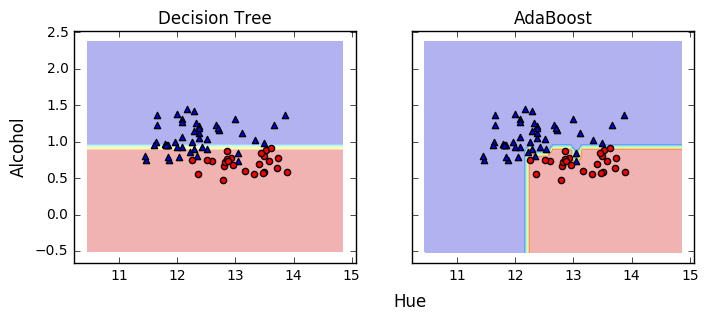

In [16]:
# 決定領域の違いを見る
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))
for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()

両者を比較するとアダブーストモデルのほうが境界が複雑になっていることが分かる<br>
アンサンブル学習全般の傾向として、予測性能の改善は比較的穏やかなものになるが、計算コストは高くなる<br>
性能と計算コストのトレードオフを理解したうえで、適用するか検討すべきである